In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm
import xarray as xr
# from matplotlib.axes import Axes
# from cartopy.mpl.geoaxes import GeoAxes
import pickle

###
from parcels import Variable, FieldSet, ParticleSet, AdvectionRK4, JITParticle
from parcels import ErrorCode, DiffusionUniformKh, Field
from datetime import timedelta
import datetime

In [138]:
infile = open('../river_sources.pkl', 'rb')
river_sources = pickle.load(infile)

In [142]:
smoc = xr.open_dataset('../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc')

In [143]:
smoc['time']

<xarray.DataArray 'time' (time: 1)>
array(['2018-01-01T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T12:00:00
Attributes:
    long_name:      Time (hours since 1950-01-01)
    standard_name:  time
    valid_min:      596100.0
    valid_max:      596100.0
    axis:           T

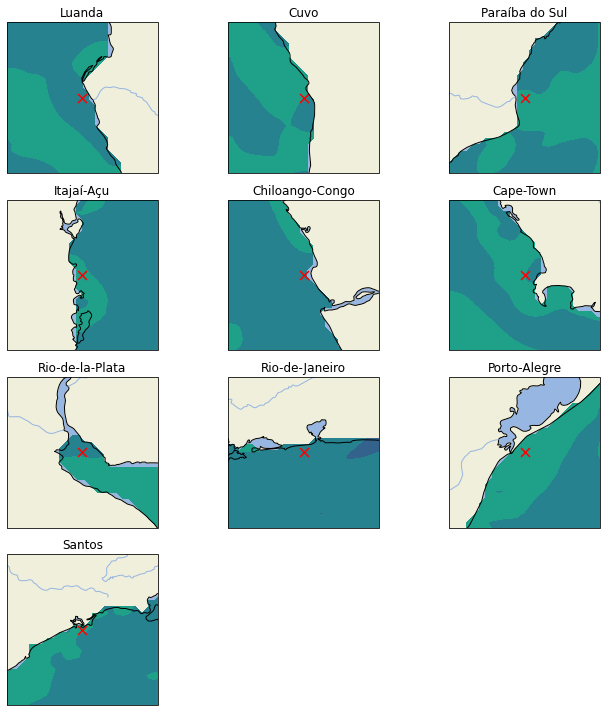

In [144]:
fig,ax = plt.subplots(ncols=3,nrows=4,figsize=(10,10),
                      subplot_kw={'projection': ccrs.PlateCarree()})
r = 1
i = 0
for k, loc in enumerate(river_sources):
    j = k%3
    lat_BA, lon_BA = river_sources[loc]
    
    ax[i,j].set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())
    ax[i,j].add_feature(cfeature.OCEAN)
    ax[i,j].add_feature(cfeature.LAND)
    ax[i,j].add_feature(cfeature.COASTLINE)
    ax[i,j].add_feature(cfeature.RIVERS)
    ax[i,j].set_title(loc)
    
    ax[i,j].contourf(smoc['longitude'], smoc['latitude'], smoc['uo'][0,0],
             transform=ccrs.PlateCarree())
    ax[i,j].scatter(lon_BA, lat_BA, s=80, marker='x', color='red')
    if j%3 == 2: i+=1 

plt.tight_layout()

ax[3,1].remove()
ax[3,2].remove()

-----
## Parcels

In [250]:
n_points = 10000  # particles per sampling site
n_days = 1  # 22*30  # number of days to simulate
K_bar = 1000  # diffusion value
stored_dt = 1  # hours
loc = 'Rio-de-la-Plata'


data = '../data/mercatorpsy4v3r1_gl12_mean_20180101_R20180110.nc'
output_path = f'../data/simulations/source_{loc}_release.nc'

In [251]:
# time range 2018-01-01 to 2019-11-27
filesnames = {'U': data,
              'V': data}

variables = {'U': 'uo',
             'V': 'vo'}  # Use utotal

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}
indices = {'lat': range(1, 900), 'lon': range(1284, 2460)}

fieldset = FieldSet.from_netcdf(filesnames, variables, dimensions,
                                allow_time_extrapolation=True, indices=indices)

In [252]:
def delete_particle(particle, fieldset, time, indices=indices):
    particle.delete()

In [253]:
# Diffusion
size2D = (fieldset.U.grid.ydim, fieldset.U.grid.xdim)

fieldset.add_field(Field('Kh_zonal', data=K_bar * np.ones(size2D),
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))
fieldset.add_field(Field('Kh_meridional', data=K_bar * np.ones(size2D),
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))

In [254]:
land_mask = np.load('../landmask.npy')

In [255]:
fieldset.add_field(Field('land', data=land_mask,
                         lon=fieldset.U.grid.lon, lat=fieldset.U.grid.lat,
                         mesh='spherical'))

In [256]:
def Beaching(particle, fieldset, time):
    """Kernel for deleting particle when beached
    Assumes that fieldset has `landmask`.
    """
    if fieldset.land[time, particle.depth, particle.lat, particle.lon] == 1:
        delete_particle(particle, fieldset, time)
        


In [257]:
with open('../river_sources.pkl', 'rb') as infile:
    river_sources = pickle.load(infile)

In [258]:
np.random.seed(2)  # to repeat experiment in the same conditions
# Create the cluster of particles around the sampling site
# with a radius of 1/24 deg (?).
time = datetime.datetime.strptime('2018-01-01 12:00:00', '%Y-%m-%d %H:%M:%S')

lon_cluster = [river_sources[loc][1]]*n_points
lat_cluster = [river_sources[loc][0]]*n_points

lon_cluster = np.array(lon_cluster)+(np.random.random(len(lon_cluster))-0.5)/24
lat_cluster = np.array(lat_cluster)+(np.random.random(len(lat_cluster))-0.5)/24
date_cluster = np.repeat(time, n_points)

In [222]:
class SampleParticleInitZero(JITParticle):            # Define a new particle class
    beaching = Variable('beaching', initial=0)  # Variable 'beaching' initially zero

#pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=lon, lat=lat, time=time)

pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=SampleParticleInitZero,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             time=date_cluster)

def SampleT(particle, fieldset, time):
         particle.beaching = fieldset.land[time, particle.depth, particle.lat, particle.lon]
sample_kernel = pset.Kernel(SampleT)    # Casting the SampleT function to a kernel.

In [223]:
pset.execute(sample_kernel, dt=0)

INFO: Compiled SampleParticleInitZeroSampleT ==> /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/17fe3447e4e5a0841abe0cbcdb6f4525_0.so


In [259]:
pset = ParticleSet.from_list(fieldset=fieldset,
                             pclass=JITParticle,
                             lon=lon_cluster,
                             lat=lat_cluster,
                             time=date_cluster)

In [260]:
beaching_kernel = pset.Kernel(Beaching) 

In [261]:
# Output file
output_file = pset.ParticleFile(name=output_path,
                                outputdt=timedelta(hours=stored_dt))

# Execute!
pset.execute(pset.Kernel(AdvectionRK4) + DiffusionUniformKh +beaching_kernel,
             runtime=timedelta(days=n_days),
             dt=timedelta(hours=1),
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: delete_particle})
output_file.close()

RuntimeError: Error during compilation:
Compilation command: gcc -Wall -fPIC -I/opt/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/include -g -O3 -m64 -o /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.so /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.c -shared -m64
Source file: /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.c
Log file: /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.log

Log output: /var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.c:146:7: error: implicit declaration of function 'delete_particle' is invalid in C99 [-Werror,-Wimplicit-function-declaration]
      delete_particle(particles, fset, time);
      ^
/var/folders/1f/8_g77d295cx2k2wjwb6pkb480000gn/T/parcels-501/61d5cf7b673d178abbe803d9842d2c2b_0.c:146:34: error: use of undeclared identifier 'fset'
      delete_particle(particles, fset, time);
                                 ^
2 errors generated.


# Check

In [225]:
particles = xr.load_dataset(f'../data/simulations/source_{loc}_release.nc')
particles

<xarray.Dataset>
Dimensions:     (obs: 25, traj: 10000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 9e+04 9e+04 9e+04 ... 1e+05 1e+05 1e+05
    time        (traj, obs) datetime64[ns] 2018-01-01T12:00:00 ... 2018-01-02...
    lat         (traj, obs) float32 -34.31895 -34.348003 ... -34.290245
    lon         (traj, obs) float32 -58.202667 -58.159775 ... -58.226254
    z           (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    beaching    (traj, obs) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.0
    parcels_mesh:           spherical

In [226]:
particles['lon'].shape

(10000, 25)

In [227]:
particles['beaching'][100,:]

<xarray.DataArray 'beaching' (obs: 25)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Dimensions without coordinates: obs
Attributes:
    long_name:      
    standard_name:  beaching
    units:          unknown

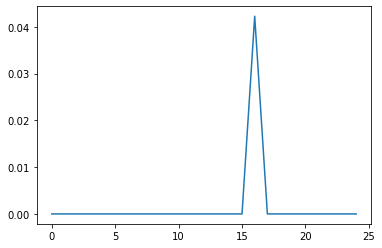

In [234]:
plt.plot(particles['beaching'][1076,:])

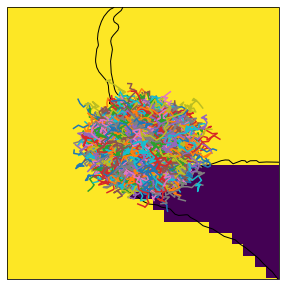

In [228]:
fig = plt.figure(figsize=(5,5))
r = 1
ax = plt.axes(projection=ccrs.PlateCarree())
lat_BA, lon_BA = river_sources[loc]
ax.pcolormesh(smoc['longitude'][indices['lon']], smoc['latitude'][indices['lat']], land_mask)
ax.set_extent([lon_BA-r, lon_BA+r, lat_BA-r, lat_BA+r], crs=ccrs.PlateCarree())

ax.coastlines()
ax.plot(particles['lon'].T, particles['lat'].T);